# Projects in Machine Learning
## Homework 1

#### Author: Matthew Uryga
#### Date: 09/09/2022

## Task 1: Problem Statement

I would like to create a model that can effectively differentiate handwritten digits.  To keep this as a classification problem, I decided to create a model that can determine if a handwritten digit is a 0 or a 7.  A logistic regression model is ideal for this problem, as the end goal is to classify a digit as a 0 or a 7, which is a binary outcome.  We can represent a '7' digit as a 1 and a '0' digit as a 0, and effectively utilize logistic regression to classify digits.

## Task 2: Dataset Selection

The go-to dataset for simple handwritten digits is the MNIST dataset - this can be accessed via http://yann.lecun.com/exdb/mnist/.  It contains 60,000 training images and 10,000 testing images of handwritten digits.  Each digit is represented as a 28x28 grayscale image, where each pixel can be an integer from 0 to 255.

Because we are only going to be distinguishing between 0s and 7s, all other handwritten digits can be ignored.  This leaves us with 12,188 training images and 2008 testing images, which is still plenty for a simple logistic regression.

It is infeasible to use each pixel as a direct input to the model, thus each image was processed to extrapolate two defining features that are hopefully different between 0s and 7s.
The two features are:
- The difference in average pixel intensity over the x-axis
- The difference in average pixel intensity over the y-axis
The reasoning behind these features is that most 0s will be symmetrical over both the x and y axes, while most 7s will be asymmetrical over both axes.

The resulting features were then normalized to a range of (0,1), and were stored as floats.

In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import mnist_loader

Download complete.
Save complete.


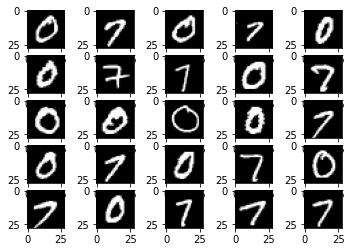

<Figure size 432x288 with 0 Axes>

In [5]:
# get mnist data from source
# http://yann.lecun.com/exdb/mnist/
mnist_loader.init()
train_img, train_y, test_img, test_y = mnist_loader.load()

# loader returns flattened images, reshape into 28x28 images
train_img = np.reshape(train_img, (60000, 28, 28))
train_y = np.reshape(train_y, (60000, ))
test_img = np.reshape(test_img, (10000, 28, 28))
test_y = np.reshape(test_y, (10000, ))

# extract only 0 and 7 images and labels
valid_nums = (train_y == 0) | (train_y == 7)
train_img = train_img[valid_nums]
train_y = train_y[valid_nums]
valid_nums = (test_y == 0) | (test_y == 7)
test_img = test_img[valid_nums]
test_y = test_y[valid_nums]

# set all 7-labels to 1
# 1 represents a seven, 0 represents a 0
train_y[train_y == 7] = 1
test_y[test_y == 7] = 1

# visualize some of the training examples
fig, ax = plt.subplots(5,5)
for i in range(0, 5):
	for j in range(0, 5):
		ax[i][j].imshow(train_img[5*i+j], cmap='gray')
plt.show()
plt.clf()

As shown above, most of the 0s are relatively symmetrical, while the 7s are not.  We can extract the aforementioned features, and plot them on a 2d plane to see if there are any obvious patterns or groups.

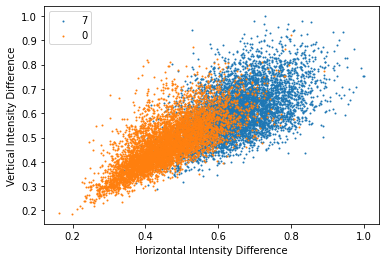

<Figure size 432x288 with 0 Axes>

In [8]:
# extract features from images
# feature1: Horizontal Intensity Difference
# feature2: Vertical Intensity Difference
train_X = np.zeros((train_img.shape[0], 2))
test_X = np.zeros((test_img.shape[0], 2))
for i, img in enumerate(train_img):
	train_X[i][0] = np.abs(np.mean(img[:, :14] - img[:, 14:]))
	train_X[i][1] = np.abs(np.mean(img[:14] - img[14:]))

for i, img in enumerate(test_img):
	test_X[i][0] = np.mean(img)
	test_X[i][1] = np.abs(np.mean(img[:14] - img[14:]))

# normalize features
train_X = train_X/np.max(train_X)
test_X = test_X/np.max(test_X)

# visualize both features to determine if there are any obvious groups
plt.scatter([train_X[i][0] for i in range(len(train_X)) if train_y[i] == 0], [train_X[i][1] for i in range(len(train_X)) if train_y[i] == 0], s = 1, label = '7')
plt.scatter([train_X[i][0] for i in range(len(train_X)) if train_y[i] == 1], [train_X[i][1] for i in range(len(train_X)) if train_y[i] == 1], s = 1, label = '0')
plt.xlabel('Horizontal Intensity Difference')
plt.ylabel('Vertical Intensity Difference')
plt.legend()
plt.show()
plt.clf()

The above plot shows that the 0s generally have smaller differences across the x and y axes, as expected. 

## Task 3: Logistic Regression

Cost function: $L = -\frac{1}{n}\sum_{i=1}^m\left(y^{(i)}\log\left(a^{(i)}\right)+\left(1-y^{(i)}\right)\log(\left(1-a^{(i)}\right)\right)$

Derivatives: $\frac{\partial L}{\partial w} = \frac{1}{n}X(A-Y)^T$ $\hspace{1cm}$ $\frac{\partial L}{\partial b} = \frac{1}{n}\sum_{i=1}^n\left(a^{(i)}-y^{(i)}\right)$

### Batch Gradient Descent

In [9]:
def get_batch(X, y, batch_size):
	'''
	generator that yields batches of data
	'''
	# generate random sequence of X so that batches are different
	seq = np.random.permutation(len(X))
	# create batches of size batch_size
	for i in range(0, len(X)//batch_size):
		# stack ones to simplify weight and bias calculations later on
		out_X = np.vstack((np.ones(batch_size), X[seq[i:i+batch_size]].T)).T
		out_y = y[seq[i:i+batch_size]]
		yield out_X, out_y

In [11]:
def grad_descent(num_epochs, batch_size, learning_rate):
	'''
	function to calculate gradient descent
	'''
	losses = []

	# weight matrix
	W = np.zeros((1,3))

	# iterate for specified number of epochs
	for epoch in tqdm(range(num_epochs)):
		# for each epoch, split data into batches and run grad descent on them
		for X, y in get_batch(train_X, train_y, batch_size):
			# forward pass -> compute predictions
			# using sigmoid
			preds = 1 / (1 + np.exp(-1 * (W @ X.T)))

			# calculate loss
			loss = np.mean(-1 * y * np.log(preds) - (1 - y) * np.log(1 - preds))

			# calculate gradient
			grad = (X.T @ (preds - y).T) / batch_size

			# backwards pass -> update weight matrix
			W -= learning_rate * grad.T

			# track losses
			losses.append(loss)

	return losses, W

In [12]:
def calculate_accuracy(X, y, W):
	'''
	function to calculate accuracy given data and weight matrix
	'''
	# reshape data
	X, y = next(get_batch(X, y, len(X)))

	# calculate predictions using sigmoid
	preds = 1 / (1 + np.exp(-1 * (W @ X.T)))

	# if above 0.5, predict a 1 (7), otherwise predict a 0 (0)
	preds[preds > 0.5] = 1
	preds[preds < 0.5] = 0
	return np.mean(preds == y)

BATCH GRADIENT DESCENT:


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 732.97it/s]


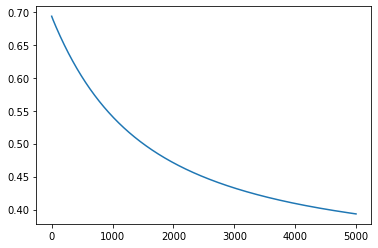

	Training accuracy: 85.1165%
	Testing accuracy:  70.4681%


<Figure size 432x288 with 0 Axes>

In [28]:
# BATCH GRADIENT DESCENT
print('BATCH GRADIENT DESCENT:')
bgd_losses, W = grad_descent(5000, len(train_X), 0.1)

# plot losses over time
plt.plot(bgd_losses)
plt.show()
plt.clf()

# calculate training and testing accuracy
print(f'\tTraining accuracy: {calculate_accuracy(train_X, train_y, W)*100:.4f}%')
print(f'\tTesting accuracy:  {calculate_accuracy(test_X, test_y, W)*100:.4f}%')

MINI BATCH GRADIENT DESCENT (BATCH SIZE 1000):


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 570.73it/s]


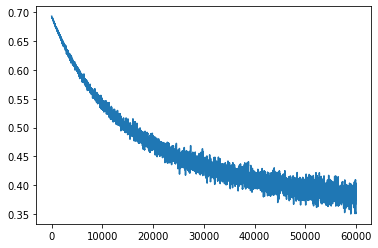

	Training accuracy: 85.2068%
	Testing accuracy:  70.2191%


<Figure size 432x288 with 0 Axes>

In [15]:
# MINI BATCH GRADIENT DESCENT
print('MINI BATCH GRADIENT DESCENT (BATCH SIZE 1000):')
mbgd_losses, W = grad_descent(5000, 1000, 0.01)

# plot losses over time
plt.plot(mbgd_losses)
plt.show()
plt.clf()

# calculate training and testing accuracy
print(f'\tTraining accuracy: {calculate_accuracy(train_X, train_y, W)*100:.4f}%')
print(f'\tTesting accuracy:  {calculate_accuracy(test_X, test_y, W)*100:.4f}%')

Based on the data above, it appears that batch and mini batch gradient descent have very similar accuracy.

## Task 4: Optimization

### RMSprop Optimizer

In [18]:
def grad_descent_rms(num_epochs, batch_size, learning_rate):
	'''
	function to calculate gradient descent with rmsprop optimizer
	'''
	# constants as recommended in the paper
	gamma = 0.9
	eps = 1e-8

	losses = []

	# weight matrix
	W = np.zeros((1,3))

	# variable to store previous E value
	E_p = 0

	# iterate for specified number of epochs
	for epoch in tqdm(range(num_epochs)):
		# for each epoch, split data into batches and run grad descent on them
		for X, y in get_batch(train_X, train_y, batch_size):
			# forward pass -> compute predictions
			# using sigmoid
			preds = 1 / (1 + np.exp(-1 * (W @ X.T)))

			# calculate loss
			loss = np.mean(-1 * y * np.log(preds) - (1 - y) * np.log(1 - preds))

			# calculate gradient
			grad = (X.T @ (preds - y).T) / batch_size

			# calculate E
			E = gamma * E_p + (1 - gamma) * grad**2

			# backwards pass -> update weight matrix using adam parameters
			W -= ((learning_rate * grad) / (np.sqrt(E+eps))).T

			# track losses
			losses.append(loss)

	return losses, W

### Adam Optimizer

In [19]:
def grad_descent_adam(num_epochs, batch_size, learning_rate):
	'''
	function to calculate gradient descent with adam optimizer
	'''
	# constants as recommended in the paper
	b_1 = 0.9
	b_2 = 0.999
	eps = 1e-8

	# variables to store previous moments
	m_p = 0
	v_p = 0

	losses = []

	i = 1
	# weight matrix
	W = np.zeros((1,3))
	# iterate for specified number of epochs
	for epoch in tqdm(range(num_epochs)):
		# for each epoch, split data into batches and run grad descent on them
		for X, y in get_batch(train_X, train_y, batch_size):
			# forward pass -> compute predictions
			# using sigmoid
			preds = 1 / (1 + np.exp(-1 * (W @ X.T)))

			# calculate loss
			loss = np.mean(-1 * y * np.log(preds) - (1 - y) * np.log(1 - preds))

			# calculate gradient
			grad = (X.T @ (preds - y).T) / batch_size

			# update adam moments
			m_t = (b_1 * m_p) + (1 - b_1) * grad
			v_t = (b_2 * v_p) + (1 - b_2) * grad**2

			# update previous moment values
			m_p = np.copy(m_t)
			v_p = np.copy(v_t)

			# correct moments for bias
			m_t /= (1 - b_1**i)
			v_t /= (1 - b_2**i)
			i += 1

			# backwards pass -> update weight matrix using adam parameters
			W -= ((learning_rate * m_t) / (np.sqrt(v_t) + eps)).T

			# track losses
			losses.append(loss)

	return losses, W

BATCH GRADIENT DESCENT WITH RMSPROP:


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 687.71it/s]


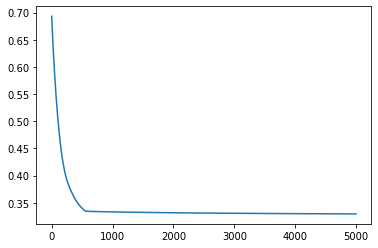

	Training accuracy: 85.9452%
	Testing accuracy:  68.8247%


<Figure size 432x288 with 0 Axes>

In [20]:
print('BATCH GRADIENT DESCENT WITH RMSPROP:')
rms_losses, W = grad_descent_rms(5000, len(train_X), 0.01)

# plot losses over time
plt.plot(rms_losses)
plt.show()
plt.clf()

# calculate training and testing accuracy
print(f'\tTraining accuracy: {calculate_accuracy(train_X, train_y, W)*100:.4f}%')
print(f'\tTesting accuracy:  {calculate_accuracy(test_X, test_y, W)*100:.4f}%')

BATCH GRADIENT DESCENT WITH ADAM:


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 688.99it/s]


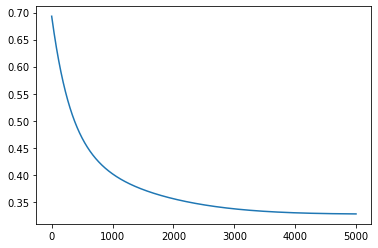

	Training accuracy: 85.8713%
	Testing accuracy:  68.3267%


<Figure size 432x288 with 0 Axes>

In [21]:
print('BATCH GRADIENT DESCENT WITH ADAM:')
adam_losses, W = grad_descent_adam(5000, len(train_X), 0.01)

# plot losses over time
plt.plot(adam_losses)
plt.show()
plt.clf()

# calculate training and testing accuracy
print(f'\tTraining accuracy: {calculate_accuracy(train_X, train_y, W)*100:.4f}%')
print(f'\tTesting accuracy:  {calculate_accuracy(test_X, test_y, W)*100:.4f}%')

Based on the data above, both the RMSprop and Adam optimizers have similar asymptotic performance, however RMSprop reaches the minimum loss asymptote much faster than Adam.

### Final Comparison

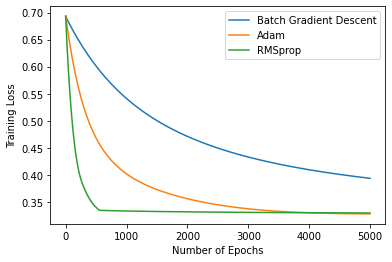

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(bgd_losses, label = 'Batch Gradient Descent')
plt.plot(adam_losses, label = 'Adam')
plt.plot(rms_losses, label = 'RMSprop')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.plot()
plt.show()
plt.clf()

As such, both optimizers perform much better than batch gradient descent on its own.  It is worth noting that the Adam optimizer takes longer to reduce the loss but it ends up producing a better model (based on training loss) when compared to the RMSprop optimizer.

When looking at the accuracy results, it is evident that using an optimizer decreases the test accuracy of the model.  This is almost certainly due to the overfitting of the training set - the training loss continues to increase and the testing loss continues to decreases as the models are trained for longer.  In fact, we can get the batch gradient descent model to emulate this by having it train for thousands more epochs.

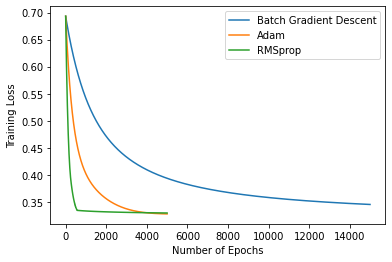

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(bgd_losses, label = 'Batch Gradient Descent')
plt.plot(adam_losses, label = 'Adam')
plt.plot(rms_losses, label = 'RMSprop')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.plot()
plt.show()
plt.clf()

When the simple gradient descent model is trained for longer, the loss decreases, but this is at the cost of test accuracy.  As such, the optimal model for this problem would be either Adam or RMSprop but trained for less time.  This would result in good accuracy for a low amount of training.